In [0]:
import re
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import sys
import os

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

np.random.seed(10)
%matplotlib inline

In [0]:
data = pd.read_csv('Combined_News_DJIA.csv')
data['Date'] = pd.to_datetime(data.Date)
train_split = 0.8
total_count = data.shape[0]
train_cut = int(total_count* train_split)
train = data.loc[: train_cut-1, :]
test = data.loc[train_cut :, :]
y_train = np.array(train["Label"])
y_test = np.array(test["Label"])

In [0]:
train.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [0]:
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))

In [0]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [0]:
word_to_vec_map['dog'].shape

(50,)

In [0]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`. 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len), dtype=int)
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j += 1
                if j >= max_len:
                    break
            
    return X_indices

In [0]:
strip_special_chars = re.compile("[^A-Za-z ]+")

def cleanSentences(string):
    # remove b"
    string = string.lower().replace("b\"", " ")
    # remove b\'
    string = string.lower().replace("b\'", "")
    return re.sub(strip_special_chars, "", string.lower())

In [0]:
a = ['b"Georgia \'downs']
np.array(list(map(lambda x:cleanSentences(x), a)))

array([' georgia downs'], dtype='<U14')

In [0]:
X_train = np.array(list(map(lambda x:cleanSentences(x), trainheadlines)))
X_test = np.array(list(map(lambda x:cleanSentences(x), testheadlines)))

In [0]:
X_train[7]

' man arrested and locked up for five hours after taking photo of police van ignoring no entry sign the us missile defence system is the magic pudding that will never run out schrder lambasted for blaming russian conflict on georgia officials  french soldiers killed near kabul  these ten laws make china a totalitarian wasteland russia seizes us vehicles  muslims are only  of denmarks  million people but make up a majority of the countrys convicted rapists practically all the female victims are nonmuslim taliban forces kill  french soldiers and raid us base assaults kidnappings and killings of humanitarian aid workers have more than doubled in the past five years  south ossetia isnt kosovo finally an olympic image to take your mind off michael phelps  pic new york laser graffiti artist detained indefinitely in beijing for tibet protest art us left isolated over nato plans to maintain relations with russia  driven shai agassis audacious plan to put electric cars on the road  nato freezes

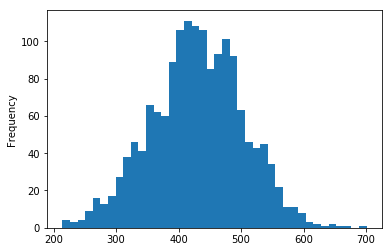

In [0]:
X_train_lengths = list(map(lambda x: len(x.split()), X_train))
df = pd.DataFrame({'counts': X_train_lengths})
df.counts.plot.hist(bins = 40)

In [0]:
X1 = np.array(['germany to meet with france'])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 9)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['germany to meet with france']
X1_indices = [[160180 360915 239785 388711 152927      0      0      0      0]]


In [0]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=True)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
embedding_layer.get_weights()[0][word_to_index['apple']]

Instructions for updating:
Colocations handled automatically by placer.


array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ], dtype=float32)

In [0]:
print('Building model 1...')
model = Sequential()
model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index))
model.add(GRU(128, dropout=0.2, return_sequences=True))
model.add(GRU(128, dropout=0.2, return_sequences=True))
model.add(GRU(128, dropout=0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Building model 1...


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 50)          20000050  
_________________________________________________________________
gru_14 (GRU)                 (None, None, 128)         68736     
_________________________________________________________________
gru_15 (GRU)                 (None, None, 128)         98688     
_________________________________________________________________
gru_16 (GRU)                 (None, 128)               98688     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 20,266,291
Trainable params: 20,266,291
Non-trainable params: 0
________________________________________________________________

In [0]:
maxlen = 500
batch_size = 50
X_train_indices = sentences_to_indices(X_train, word_to_index, maxlen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxlen)

In [0]:
# nb_classes = 2
# Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)
Y_train = y_train.reshape((-1,1))
Y_test = y_test.reshape((-1,1))

In [0]:
print('Train...')
history = model.fit(X_train_indices, Y_train, batch_size=batch_size, epochs=500,
          validation_data=(X_test_indices, Y_test))

model.save("./model.h5")
score, acc = model.evaluate(X_test_indices, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 1591 samples, validate on 398 samples
Epoch 1/500
1591/1591 [==============================] - 45s 28ms/step - loss: 0.6896 - acc: 0.5481 - val_loss: 0.6996 - val_acc: 0.5050
Epoch 2/500
1591/1591 [==============================] - 48s 30ms/step - loss: 0.6873 - acc: 0.5493 - val_loss: 0.6958 - val_acc: 0.5101
Epoch 3/500
1591/1591 [==============================] - 46s 29ms/step - loss: 0.6851 - acc: 0.5506 - val_loss: 0.7006 - val_acc: 0.5101
Epoch 4/500
1591/1591 [==============================] - 46s 29ms/step - loss: 0.6769 - acc: 0.5581 - val_loss: 0.7043 - val_acc: 0.5101
Epoch 5/500
1591/1591 [==============================] - 46s 29ms/step - loss: 0.6671 - acc: 0.5845 - val_loss: 0.7143 - val_acc: 0.5000
Epoch 6/500
1591/1591 [==============================] - 45s 28ms/step - loss: 0.6534 - acc: 0.5883 - val_loss: 0.7597 - val_acc: 0.4849
Epoch 7/500
1591/1591 [==============================] - 46s 29ms/step - loss: 0.6273 - acc: 0.6065 - val_loss: 0.7466 - v

In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test_indices).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [0]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

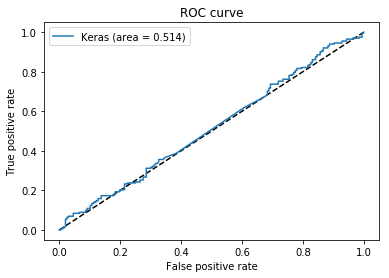

In [0]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()